# Data Visualization Analyisis

## Data Loading

In [209]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.functions import UserDefinedFunction, col, mean, log1p, UserDefinedFunction, explode, rand, when, lit, count
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml import Pipeline
from pyspark.sql.types import FloatType
import os

"""
Spark session variables declaration and spark initialization
"""

path = os.getcwd()

conf = SparkConf() \
    .setAppName("PostgreSQL Writing to Formatted Table") \
    .set("spark.jars", path+"/../.."+"/driver/postgresql-42.7.3.jar")

spark = SparkSession.builder \
    .config(conf=conf) \
    .getOrCreate()


"""
Connection details for table from formatted zone read
"""

jdbc_url = "jdbc:postgresql://localhost:5432/bda_p1"
driver_class = "org.postgresql.Driver"
user = "postgres"
password = "postgres"
connectionProperties = {"user": user, "password": password}


df_caract = spark.read \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "dog_caract_trusted") \
    .option("user", connectionProperties["user"]) \
    .option("password", connectionProperties["password"]) \
    .option("driver", driver_class) \
    .load()


df_caract.show()

+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+--------------------+-----------+--------------+--------+------------+-----------------+---------------+-------------------+------------------------------+--------------------------------+
|barking|coat_length|drooling|energy|good_with_children|good_with_other_dogs|good_with_strangers|grooming|               Breed|playfulness|protectiveness|shedding|trainability|avg_height_female|avg_height_male|avg_life_expectancy|avg_weight_male_log_normalized|avg_weight_female_log_normalized|
+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+--------------------+-----------+--------------+--------+------------+-----------------+---------------+-------------------+------------------------------+--------------------------------+
|      1|          1|       0|     0|                 3|                   3|                  0|       0|    Ameri

In [210]:
df_caract2 = spark.read \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "dog_caract2_trusted") \
    .option("user", connectionProperties["user"]) \
    .option("password", connectionProperties["password"]) \
    .option("driver", driver_class) \
    .load()

df_caract2.show()

+--------------------+------------+---+--------------------+--------------------+
|            bred_for| breed_group| id|               Breed|         temperament|
+--------------------+------------+---+--------------------+--------------------+
|Small rodent hunt...|         Toy|  1|       Affenpinscher|Stubborn, Curious...|
|Coursing and hunting|       Hound|  2|        Afghan Hound|Aloof, Clownish, ...|
|  A wild pack animal|     Working|  3| African Hunting Dog|Wild, Hardworking...|
|Badger, otter hun...|     Terrier|  4|    Airedale Terrier|Outgoing, Friendl...|
|      Sheep guarding|     Working|  5|          Akbash Dog|Loyal, Independen...|
|       Hunting bears|     Working|  6|               Akita|Docile, Alert, Re...|
|            Guarding|       Mixed|  7|Alapaha Blue Bloo...|Loving, Protectiv...|
|        Sled pulling|       Mixed|  8|       Alaskan Husky|Friendly, Energet...|
|Hauling heavy fre...|     Working|  9|    Alaskan Malamute|Friendly, Affecti...|
|              L

### Explotation zone for dog_caract2

In [211]:
from pyspark.sql.functions import split, explode


# Tenim una columna que té una llista de valors en una string
# Volem passar-la a columnes dummy

# Identifiquem totes les categories diferents dins de temperament
unique_categories = df_caract2.select(explode(split(df_caract2["temperament"], ",\s*")).alias("temperament")).distinct()

# Creem les columnes dummy
for category_row in unique_categories.collect():
    category = category_row["temperament"]
    df_caract2 = df_caract2.withColumn(category, df_caract2["temperament"].contains(category).cast("int"))

pivoted = df_caract2.groupBy("Breed").pivot("breed_group").agg(lit(1))
pivoted = pivoted.na.fill(0)
df = df_caract2.join(pivoted, 
               df_caract2.Breed == pivoted.Breed, 
               "inner").drop(pivoted.Breed) # Drop allows to remove duplicates
df_caract2 = df_caract2.distinct()

df_caract2 = df_caract2.drop(*["id", "temperament", "bred_for"])

df_caract2.show()

+------------+--------------------+------+--------+------+------+--------+----------+--------+--------+-----+--------+-----+--------+-----+---+-------------+-----+---------+----+------+---------+----+-----+-------------+--------+---------+------------+-----------+------+---------+---------+-------+-------------+------+--------+-------------+--------+-----+----+---------+------+----+--------------+----------+-----+-----------+--------+-----+------+--------------+-----+-------+--------+-------+----------+------+--------+------+-----------+--------+-----------+---------+-----+------+------+------------+--------+--------+-----------+-----------+-----------+--------+-----------+-------+----+------+---------------+--------+--------+-----+-------+------+------+---------+-------+----------+--------+------------+--------+------+---------------+----------+--------+---------+----------+-------+----+---------+------------+-------------+----------+------+--------+-------+-----------+-----+--------+

In [212]:
df_intel = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5432/bda_p1") \
    .option("dbtable", "dog_intelligence_trusted") \
    .option("user", connectionProperties["user"]) \
    .option("password", connectionProperties["password"]) \
    .option("driver", "org.postgresql.Driver") \
    .load()

df_intel.show()

+--------------------+--------------------+----+--------+
|               Breed|      Classification|obey|avg_reps|
+--------------------+--------------------+----+--------+
|       Border Collie|      Brightest Dogs|  95|     2.5|
|              Poodle|      Brightest Dogs|  95|     2.5|
|     German Shepherd|      Brightest Dogs|  95|     2.5|
|    Golden Retriever|      Brightest Dogs|  95|     2.5|
|   Doberman Pinscher|      Brightest Dogs|  95|     2.5|
|   Shetland Sheepdog|      Brightest Dogs|  95|     2.5|
|  Labrador Retriever|      Brightest Dogs|  95|     2.5|
|            Papillon|      Brightest Dogs|  95|     2.5|
|          Rottweiler|      Brightest Dogs|  95|     2.5|
|Australian Cattle...|      Brightest Dogs|  95|     2.5|
|Pembroke Welsh Corgi|Excellent Working...|  85|    10.0|
| Miniature Schnauzer|Excellent Working...|  85|    10.0|
|English Springer ...|Excellent Working...|  85|    10.0|
|Belgian Shepherd ...|Excellent Working...|  85|    10.0|
|          Sch

## Table Join

In [213]:
df = df_caract.join(df_intel, 
               df_caract.Breed == df_intel.Breed, 
               "inner").drop(df_intel.Breed) # Drop allows to remove duplicates
df = df.join(df_caract2, 
               df.Breed == df_caract2.Breed, 
               "inner").drop(df_caract2.Breed) # Drop allows to remove duplicates
df = df.distinct()

print(df.count())
df.show()

92
+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+--------------------+-----------+--------------+--------+------------+-----------------+---------------+-------------------+------------------------------+--------------------------------+--------------------+----+--------+------------+------+--------+------+------+--------+----------+--------+--------+-----+--------+-----+--------+-----+---+-------------+-----+---------+----+------+---------+----+-----+-------------+--------+---------+------------+-----------+------+---------+---------+-------+-------------+------+--------+-------------+--------+-----+----+---------+------+----+--------------+----------+-----+-----------+--------+-----+------+--------------+-----+-------+--------+-------+----------+------+--------+------+-----------+--------+-----------+---------+-----+------+------+------------+--------+--------+-----------+-----------+-----------+--------+-----------+-------+

# Univariant Analysis

In [181]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

## Numerical Variables Visualization

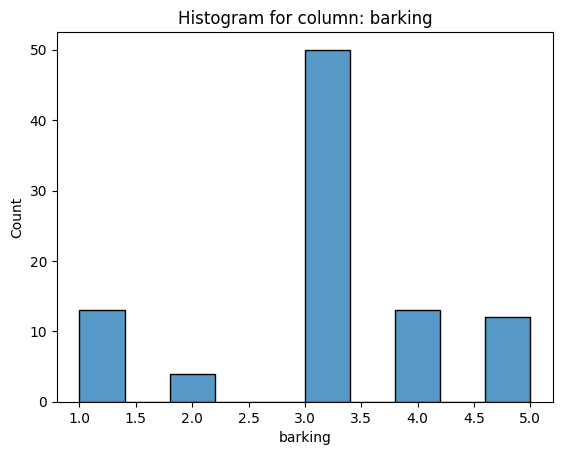

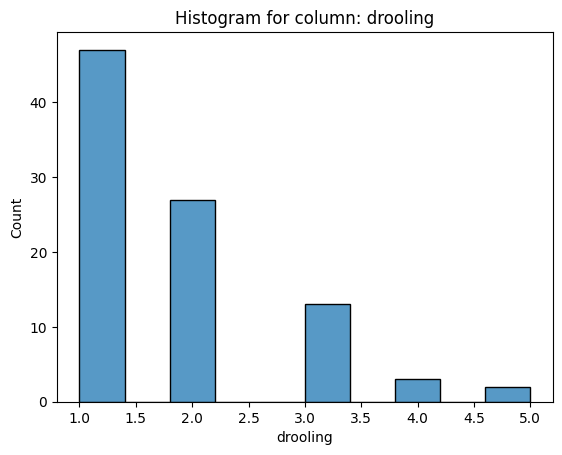

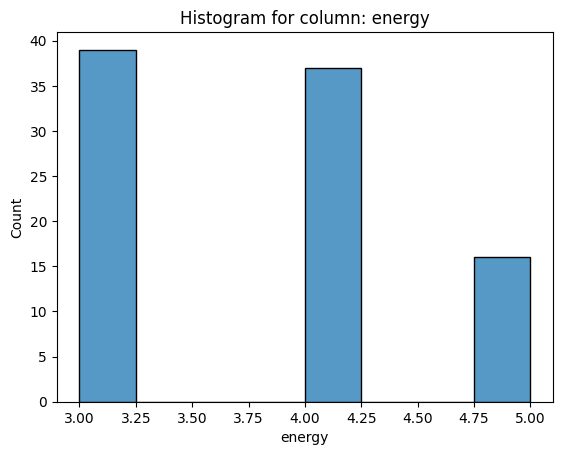

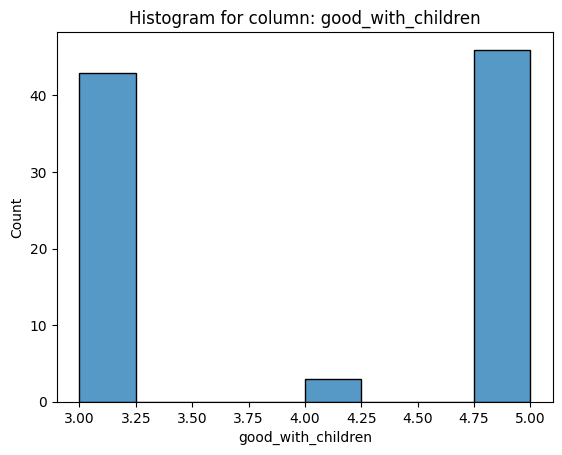

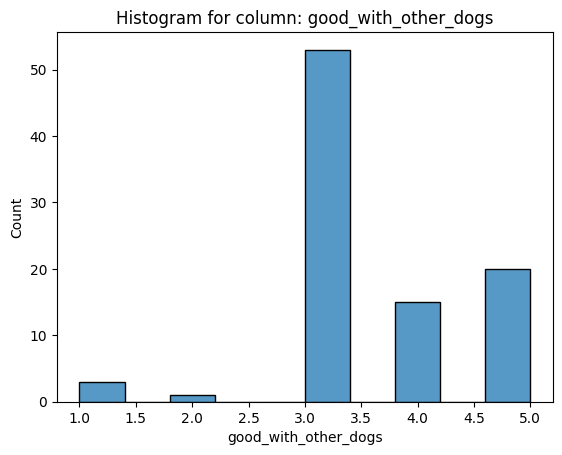

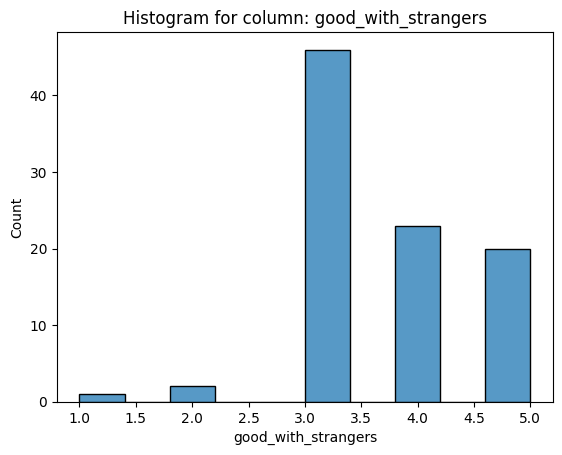

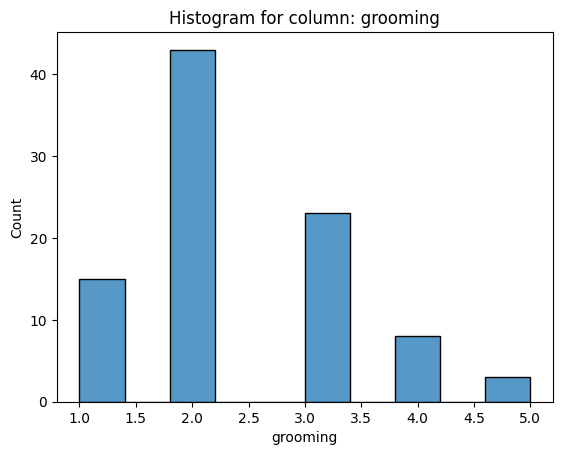

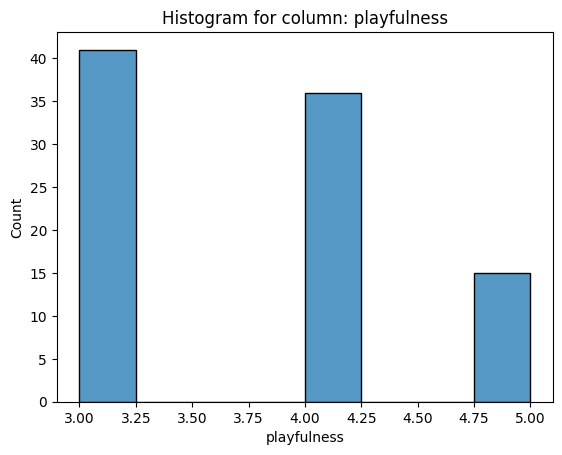

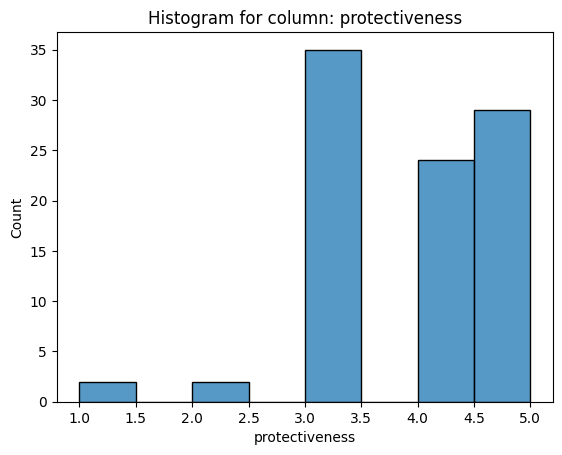

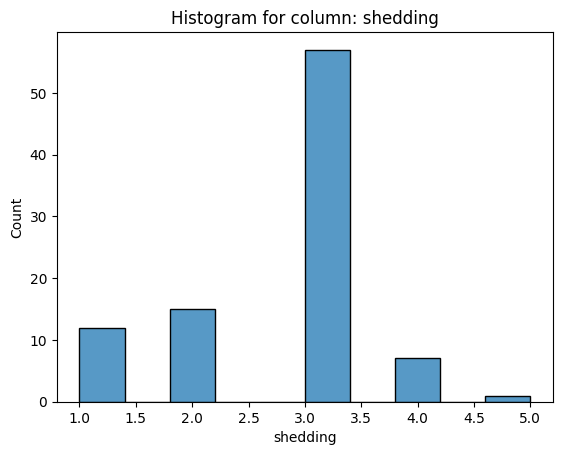

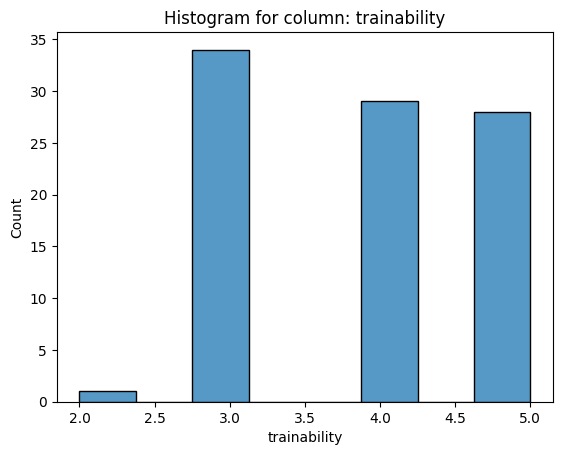

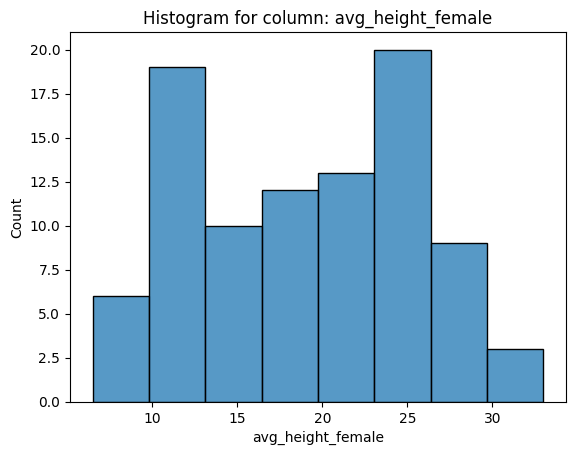

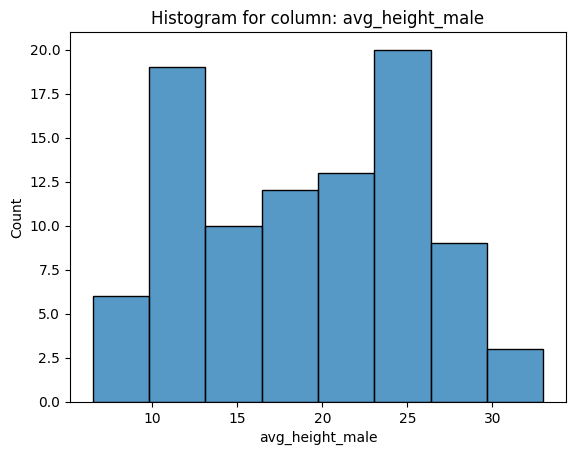

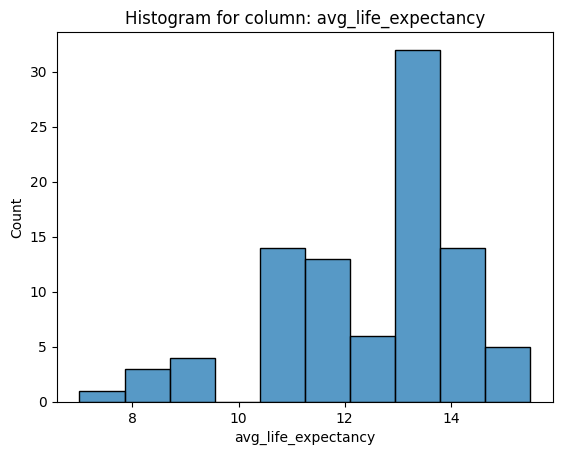

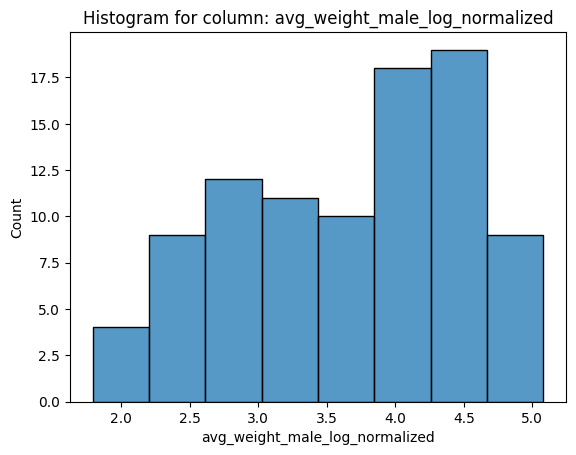

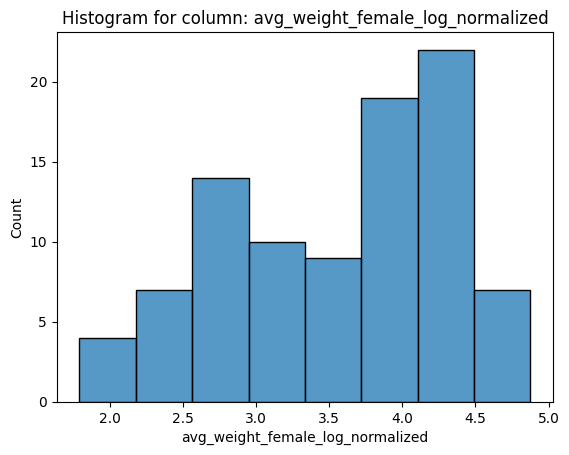

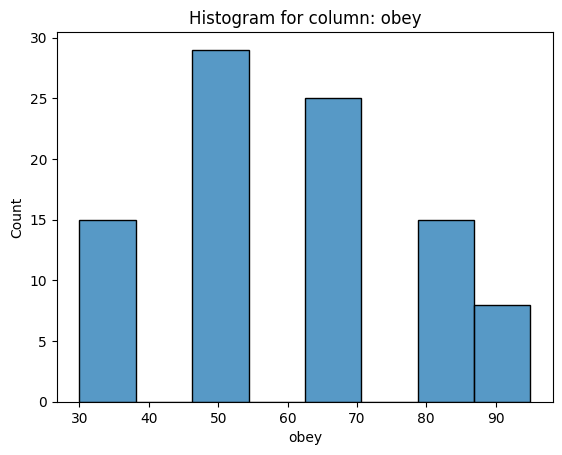

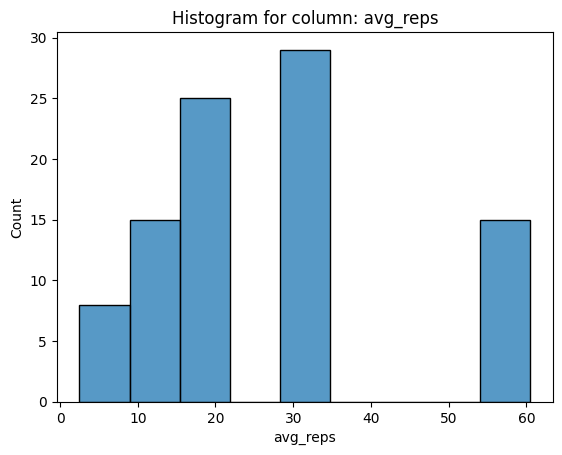

In [182]:
# Guardem en una llista totes les variables dummy
dummies = [column for column in df.columns if df.select(column).distinct().count() == 2 or df.select(column).distinct().count() == 1]

# Definim totes les numèriques menys les dummy
numeric_variables = [column for column, dtype in df.dtypes if dtype in ["int", "double", "bigint"] and column not in dummies]

# Per cada numèrica fem un histograma
for num_col in numeric_variables:
  df_pandas = df.toPandas()
  sns.histplot(data=df_pandas, x=num_col)
  plt.title(f"Histogram for column: {num_col}")
  plt.show()

Anàlisis de les variables:
- Barking: Veiem com el rang va de 1 a 5, sent 3 el valor més alt, però trobem que hi ha més races que borden molt a que borden poc.
- Coat length: Veiem com la majoria de races tenen el pèl curt, però n'hi ha algun que el té més llarg, i que es representa amb un 2.
- Drooling: Veiem com els gossos bavejen, però a mesura que augmenta el nivell de baveig, la quantitat de races que hi ha es va reduint de manera força estable.
- Energy: Pel que fa a l'energia, trobem que el rang és de 3 a 5, i que la moda està al quatre, sent el 3 el més popular i el 5 el que menys, però tampoc es queda massa curt. Veiem com totes les races de gossos presents en les dades tenen energia, però no n'hi ha tants que tinguin el nivell més alt.
- Good with children: De nou, el rang es troba entre 3 i 5, sent 3 i 5 els més populars, guanyant el 5 per ben poc, i en el nivell 4 hi ha molt poques races. Això ens mostra que els gossos mai són súper dolents amb els infants, però tenim una clara polarització entre si no son gaire bons o si són boníssims.
- Good_with_other_dogs: En aquest cas sí que trobem que hi ha instàncies del nivell més baix, tot i que mantenim el 3 com a moda i el 5 i el quatre que els segueixen, sent el nivell 1 i el 2 força minoritaris. Això mostra que en general els gossos també són bons amb altres gossos.
- Good_with_strangers: En aquesta variable veiem una distribució similar a la anterior però el nivell 4 és més popular que el 5. Per tant, en general també són bons amb desconeguts.
- Grooming: Pel que fa a si van bé per a netejar-los o tallar-lis el pèl, veiem com la moda és al centre, però la majoria no van bé, escepte una minoria que sí 
- Playfulness: Tots són juganers, però la moda és el 3, sent el 4 i el 5 una mica menys representats però tampoc tant poc. 
- Protectiveness: La majoria són protectors (van ser entrenats durant segles per això), estant entre 3 i 5, i sent el 1 i el 2 minoritaris però no inexistents.
- Shedding: La majoria de gossos ni deixen molt de pèl ni en deixen poc, estàn al centre (3), tot i així, veiem una distribució normal cap a les dues bandes, sent el 2 i el 4 els següents més populars i als extrems hi ha menys races, tot i que hi ha més races que deixen poc pèl que les que en deixen molt. 
- Trainability: La majoria són facils d'entrenar, sent el 3 el valor més popular, seguit del 4 i després el 5 de ben a prop. Tenim algun 2 minoritari.
- Pel que fa a l'alçada, no veiem diferències entre la dels mascles i les famelles, ja que comparteixen la mateixa distribució en el mateix rang.
- Pel que fa a l'esperança de vida, la majoria es troben al voltant dels 13 anys, però hi ha gossos que no tenen més de 7 anys d'esperança.
- Pel que fa a si són obedients o no, veiem com una distribució força normal centrada en 50%, però aquest valor pot arribar fins a més del 90% o fins al 30%.

## Categorical Variables Visualization

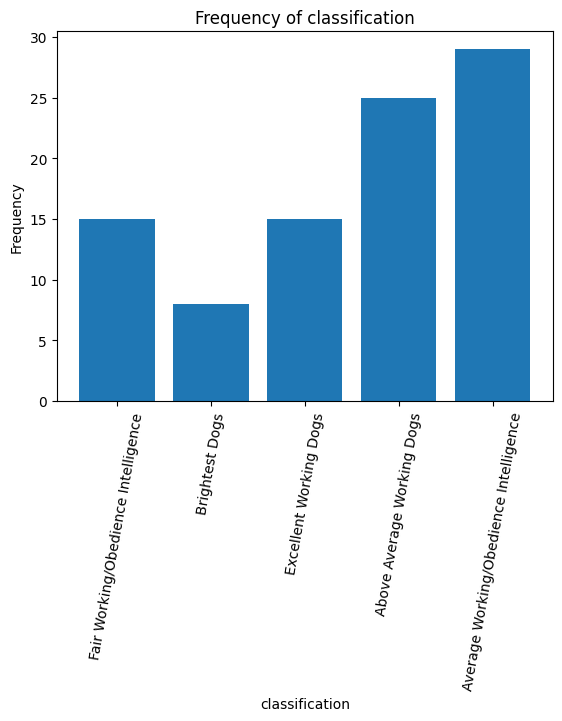

In [183]:
df_pandas = df.toPandas()

selected_column = "classification"

# Ajuntem les files per la variable i contem quantes files de cada hi ha
frequency_counts = df.groupBy(selected_column).agg(count(col(selected_column)).alias("count"))

# Passem a pandas
frequency_counts_pandas = frequency_counts.toPandas()

# Fem un barplot de la variable classification
plt.xticks(rotation=80)
plt.bar(frequency_counts_pandas[selected_column], frequency_counts_pandas["count"])
plt.xlabel(selected_column)
plt.ylabel("Frequency")
plt.title(f"Frequency of {selected_column}")
plt.show()


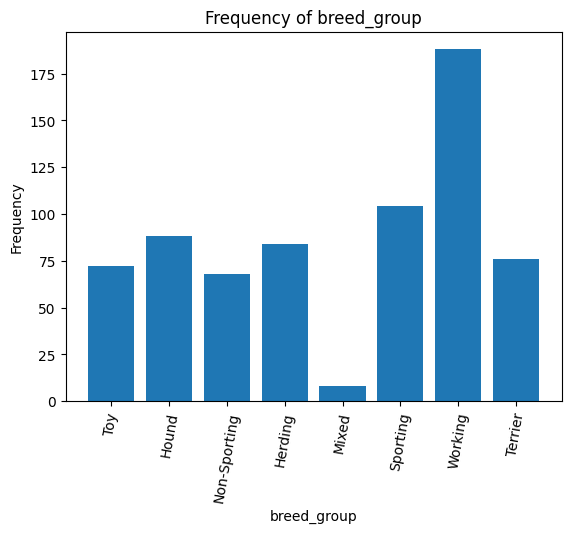

In [189]:
df_pandas = df.toPandas()

selected_column = "breed_group"

# Ajuntem les files per la variable i contem quantes files de cada hi ha
frequency_counts = df.groupBy(selected_column).agg(count(col(selected_column)).alias("count"))

# Passem a pandas
frequency_counts_pandas = frequency_counts.toPandas()

# Fem un barplot de la variable breed_group
plt.xticks(rotation=80)
plt.bar(frequency_counts_pandas[selected_column], frequency_counts_pandas["count"])
plt.xlabel(selected_column)
plt.ylabel("Frequency")
plt.title(f"Frequency of {selected_column}")
plt.show()

# Bivariant Analysis

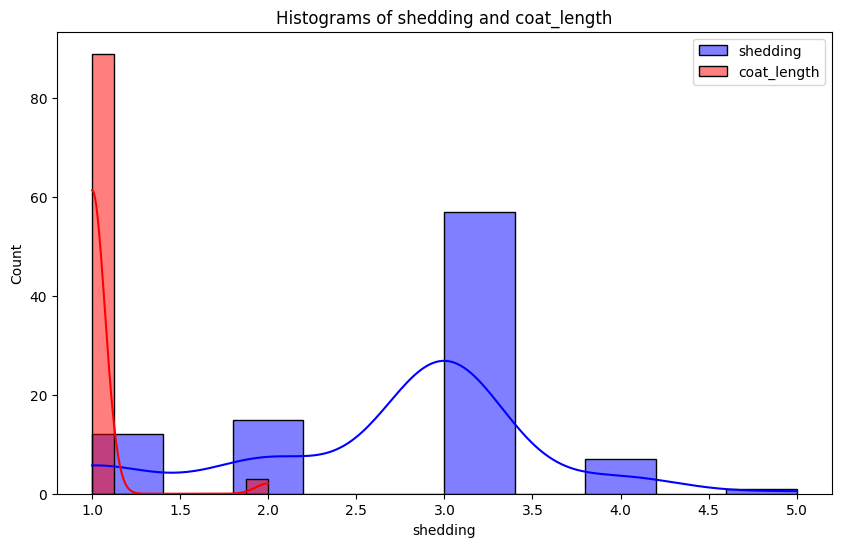

In [ ]:
x_column = "shedding"
y_column = "coat_length"

df_pd = df.select(x_column, y_column).toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(df_pd[x_column], kde=True, color='blue', label=x_column)
sns.histplot(df_pd[y_column], kde=True, color='red', label=y_column)
plt.title('Histograms of ' + x_column + ' and ' + y_column)
plt.legend()
plt.show()

Hem pensat que potser tindria relació la quantitat de pel que deixa un gos amb la llargada d'aquest, però hem vist que la majoria de gossos tenen pel curt i igualment en deixen anar molt. 

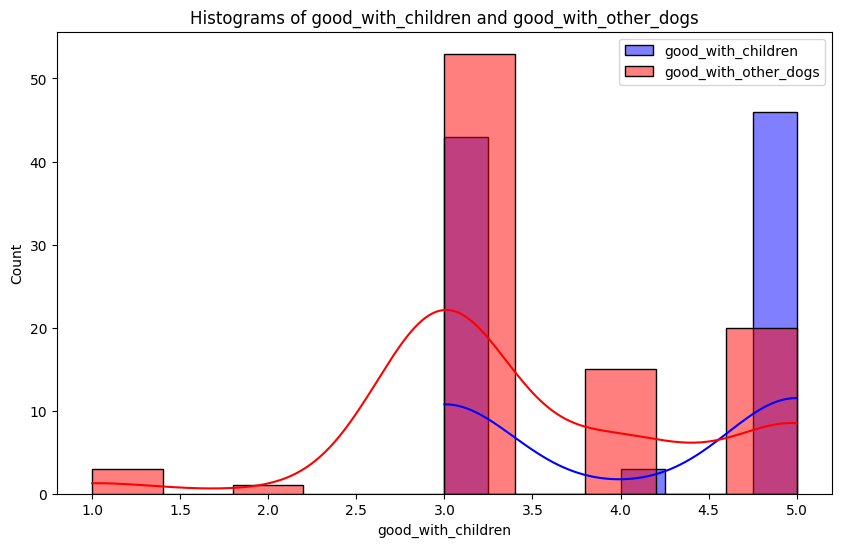

In [ ]:
x_column = "good_with_children"
y_column = "good_with_other_dogs"

df_pd = df.select(x_column, y_column).toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(df_pd[x_column], kde=True, color='blue', label=x_column)
sns.histplot(df_pd[y_column], kde=True, color='red', label=y_column)
plt.title('Histograms of ' + x_column + ' and ' + y_column)
plt.legend()
plt.show()

Hem volgut mirar també si els gossos que són bons amb els nens i nenes també seran bons amb altres gossos. No sabem si són els mateixos, però almenys segueixen una distribució similar.

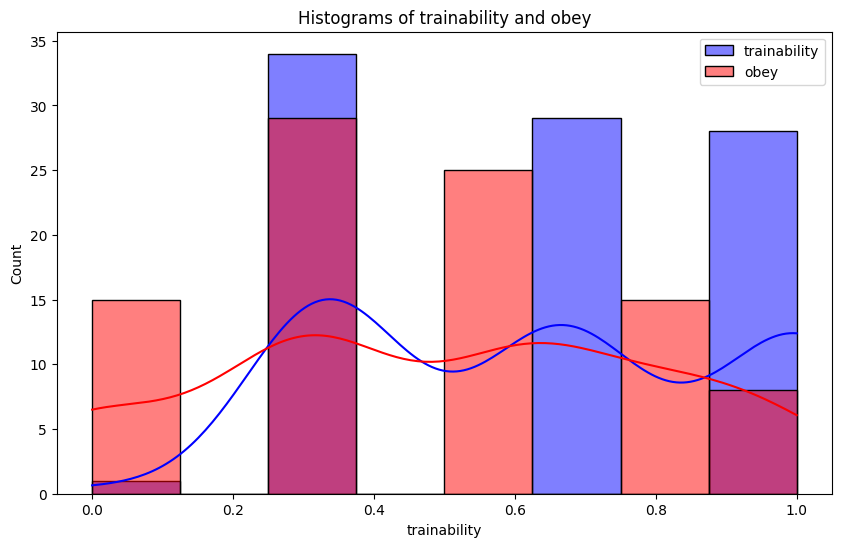

In [ ]:
from sklearn.preprocessing import MinMaxScaler

x_column = "trainability"
y_column = "obey"

df_pd = df.select(x_column, y_column).toPandas()

scaler = MinMaxScaler()
df_pd[[x_column, y_column]] = scaler.fit_transform(df_pd[[x_column, y_column]])


plt.figure(figsize=(10, 6))
sns.histplot(df_pd[x_column], kde=True, color='blue', label=x_column)
sns.histplot(df_pd[y_column], kde=True, color='red', label=y_column)
plt.title('Histograms of ' + x_column + ' and ' + y_column)
plt.legend()
plt.show()

Finalment, hem volgut mirar si hi haurà alguna relació entre la capacitat dels gossos d'entrenar les seves habilitats i lo obediens que són. Hem vist que tenen hi ha més races que entrenen bé i gossos que no obeeixen.

# Multivariant Analysis

## Clustering

In [ ]:
from pyspark.ml.clustering import KMeans 
from pyspark.ml.evaluation import ClusteringEvaluator 

### Data preparation

In [193]:
# Dummy cols...
pivoted = df.groupBy("Breed").pivot("classification").agg(lit(1))
pivoted = pivoted.na.fill(0)
df = df.join(pivoted, 
               df.Breed == pivoted.Breed, 
               "inner").drop(pivoted.Breed) # Drop allows to remove duplicates
df = df.distinct()
print(df.count())
df.show()

92
+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+-----------+--------------+--------+------------+-----------------+---------------+-------------------+------------------------------+--------------------------------+--------------------+----+--------+------+--------+------+------+--------+----------+--------+--------+-----+--------+-----+--------+-----+---+-------------+-----+---------+----+------+---------+----+-----+-------------+--------+---------+------------+-----------+------+---------+---------+-------+-------------+------+--------+-------------+--------+-----+----+---------+------+----+--------------+----------+-----+-----------+--------+-----+------+--------------+-----+-------+--------+-------+----------+------+--------+------+-----------+--------+-----------+---------+-----+------+------+------------+--------+--------+-----------+-----------+-----------+--------+-----------+-------+----+------+---------------+------

In [194]:
df = df.drop('Breed') # It does not make sense as there is one breed per row
df = df.drop('classification') # It does not make sense as we have it encoded now
df = df.drop("breed_group") # Ja la tenim en dummy columns

df.show()

+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+-----------+--------------+--------+------------+-----------------+---------------+-------------------+------------------------------+--------------------------------+----+--------+------+--------+------+------+--------+----------+--------+--------+-----+--------+-----+--------+-----+---+-------------+-----+---------+----+------+---------+----+-----+-------------+--------+---------+------------+-----------+------+---------+---------+-------+-------------+------+--------+-------------+--------+-----+----+---------+------+----+--------------+----------+-----+-----------+--------+-----+------+--------------+-----+-------+--------+-------+----------+------+--------+------+-----------+--------+-----------+---------+-----+------+------+------------+--------+--------+-----------+-----------+-----------+--------+-----------+-------+----+------+---------------+--------+--------+-----+------

In [141]:
print(df.columns)

['barking', 'coat_length', 'drooling', 'energy', 'good_with_children', 'good_with_other_dogs', 'good_with_strangers', 'grooming', 'playfulness', 'protectiveness', 'shedding', 'trainability', 'avg_height_female', 'avg_height_male', 'avg_life_expectancy', 'avg_weight_male_log_normalized', 'avg_weight_female_log_normalized', 'obey', 'avg_reps', 'Sturdy', 'Outgoing', 'Clever', 'Steady', 'Cheerful', 'Suspicious', 'Trusting', 'Composed', 'Eager', 'Reliable', 'Bossy', 'Rational', 'Brave', 'Gay', 'Even Tempered', 'Hardy', 'Attentive', 'Calm', 'Spunky', 'Dignified', 'Kind', 'Loyal', 'Great-hearted', 'Vigilant', 'Receptive', 'Affectionate', 'Trustworthy', 'Joyful', 'Excitable', 'Assertive', 'Playful', 'Strong Willed', 'Lively', 'Reserved', 'Good-tempered', 'Spirited', 'Quick', 'Fast', 'Energetic', 'Rugged', 'Wild', 'Sweet-Tempered', 'Thoughtful', 'Aloof', 'Hardworking', 'Charming', 'Merry', 'Docile', 'Self-important', 'Agile', 'Lovable', 'Familial', 'Dutiful', 'Boisterous', 'Active', 'Generous',

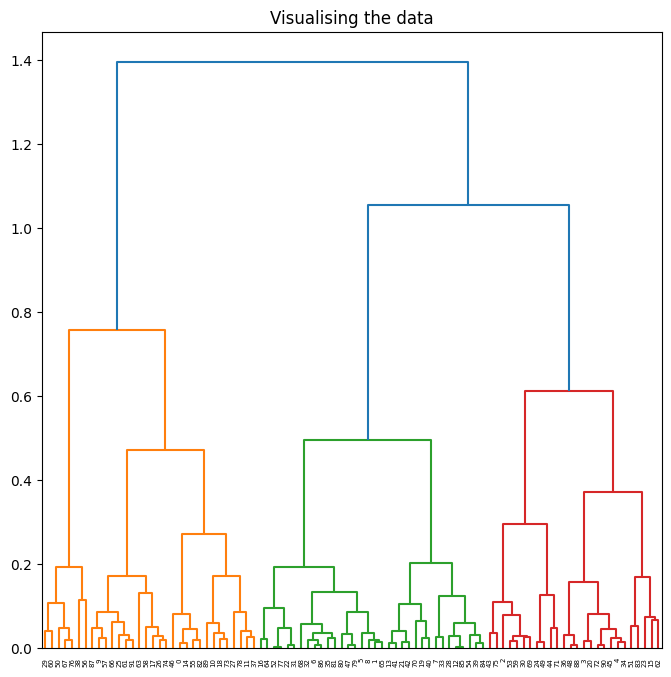

In [198]:
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
import numpy as np
from sklearn.decomposition import PCA


assembler = VectorAssembler(inputCols=df.columns, outputCol="features")
data_df = assembler.transform(df)

# Scaling the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data_df)
data_df = scaler_model.transform(data_df)

# Extracting the features from the DataFrame
X = np.array(data_df.select("scaled_features").rdd.map(lambda row: row.scaled_features.toArray()).collect())

X_normalized = normalize(X)

# Reduim dimensionalitat
pca = PCA(n_components = 2)
X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

# Mostrem el dendograma
plt.figure(figsize =(8, 8))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_principal, method ='ward')))

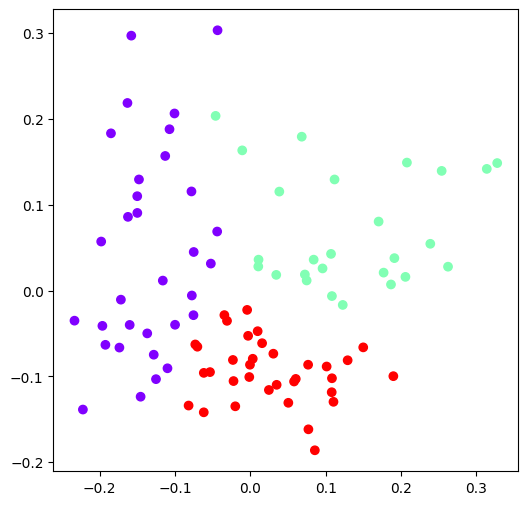

In [202]:
from sklearn.cluster import AgglomerativeClustering

ac2 = AgglomerativeClustering(n_clusters = 3)

# Visualitzem el clustering
plt.figure(figsize =(6, 6))
plt.scatter(X_principal['P1'], X_principal['P2'], 
           c = ac2.fit_predict(X_principal), cmap ='rainbow')
plt.show()